# Packages

In [3]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

import matplotlib.dates as mdates

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import datetime

# Importation des données

In [4]:
df = pd.read_csv("2025-09-MD.csv")

In [5]:
df = df[1:]

In [6]:
df = df.rename(columns = {"sasdate" : "date"})

In [7]:
df.index = pd.to_datetime(df["date"])
df = df.drop("date", axis = 1)

We have 127 variables. We need to verify if the date est de 1959 to 2025 par ordre de mensualité. After that, let's check if our interested variables are on the dataset. 

# 1. Verify the frequence and the date of time series

In [8]:
# Beginning and the end of the time series
print(df.index[0])
print(df.index[-1])

1959-01-01 00:00:00
2025-08-01 00:00:00


We observe that the dataset is vary 1959 to 2025. We normaly find the frequence of quaterly.

In [9]:
pd.infer_freq(df.index)

'MS'

The Monthly periods starting in December. 

# 2.Choosen Variables

In [10]:
col_names = ["UNRATE", 
             # Unemployement
              "TB3MS", # 3-month treasury bill
                "RPI", # Industrial personal income
                "INDPRO", # Industrial production
                "DPCERA3M086SBEA", # Consumption
                "S&P 500", # S&P 500
                "BUSLOANS", # BUSLOANS
                "CPIAUCSL", # CPIAUCSL
                "OILPRICEx", # OILPRICEx
                "M2SL"]

df = df[col_names]

In [11]:
df.describe()

,UNRATE,TB3MS,RPI,INDPRO,DPCERA3M086SBEA,S&P 500,BUSLOANS,CPIAUCSL,OILPRICEx,M2SL
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,5.864000,4.361487,9688.818986,68.044132,57.369129,1006.499925,873.237505,140.715200,33.483440,5595.068625
std,1.685588,3.108304,5170.562291,26.957102,31.281718,1297.537755,807.712035,85.197372,29.754077,5968.648344
min,3.400000,0.010000,2583.560000,21.961600,15.188000,53.730000,35.130400,28.970000,2.920000,286.600000
25%,4.600000,2.127500,5157.535000,45.069275,29.164000,101.200000,183.251000,54.500000,11.160000,989.400000
50%,5.600000,4.450000,8501.858000,63.023350,49.381500,412.530000,621.635500,139.550000,22.292500,3398.700000
75%,6.900000,5.815000,13790.407500,95.992275,84.472250,1331.650000,1249.319200,214.742000,51.677500,8226.100000
max,14.800000,16.300000,22918.422000,104.211500,124.805000,6408.950000,3035.797700,323.364000,133.930000,22195.400000


- UNRATE: Civilian unemployment rate, percent of labor force.
- TB3MS: 3-Month Treasury Bill Rate, percent per annum (yield).
- RPI: Real Personal Income, billions of chained 2012 U.S. dollars (SAAR).
- INDPRO: Industrial Production Index, index (2017 = 100).
- DPCERA3M086SBEA: Real Personal Consumption Expenditures, billions of chained 2012 U.S. dollars (SAAR).
- S&P 500: Standard & Poor’s 500 Index, index level (price index, no dividends).
- BUSLOANS: Commercial and Industrial Loans, billions of U.S. dollars.
- CPIAUCSL: Consumer Price Index for All Urban Consumers, index (1982–84 = 100).
- OILPRICEx: Crude Oil, West Texas Intermediate (WTI), U.S. dollars per barrel.
- M2SL: M2 Money Stock, billions of U.S. dollars.

# 3.NA Gestion

In [12]:
print(f"Number of missing values : {df.isna().sum().sum()}")

Number of missing values : 0


# 4.Plot Time Series

We cannot see the evolution of some Time Series.

In [13]:
# --- 2) Passer en format long
df_long = (
    df.reset_index()
      .melt(id_vars="date", var_name="series", value_name="value")
      .dropna(subset=["value"])
      .sort_values(["series", "date"])
)

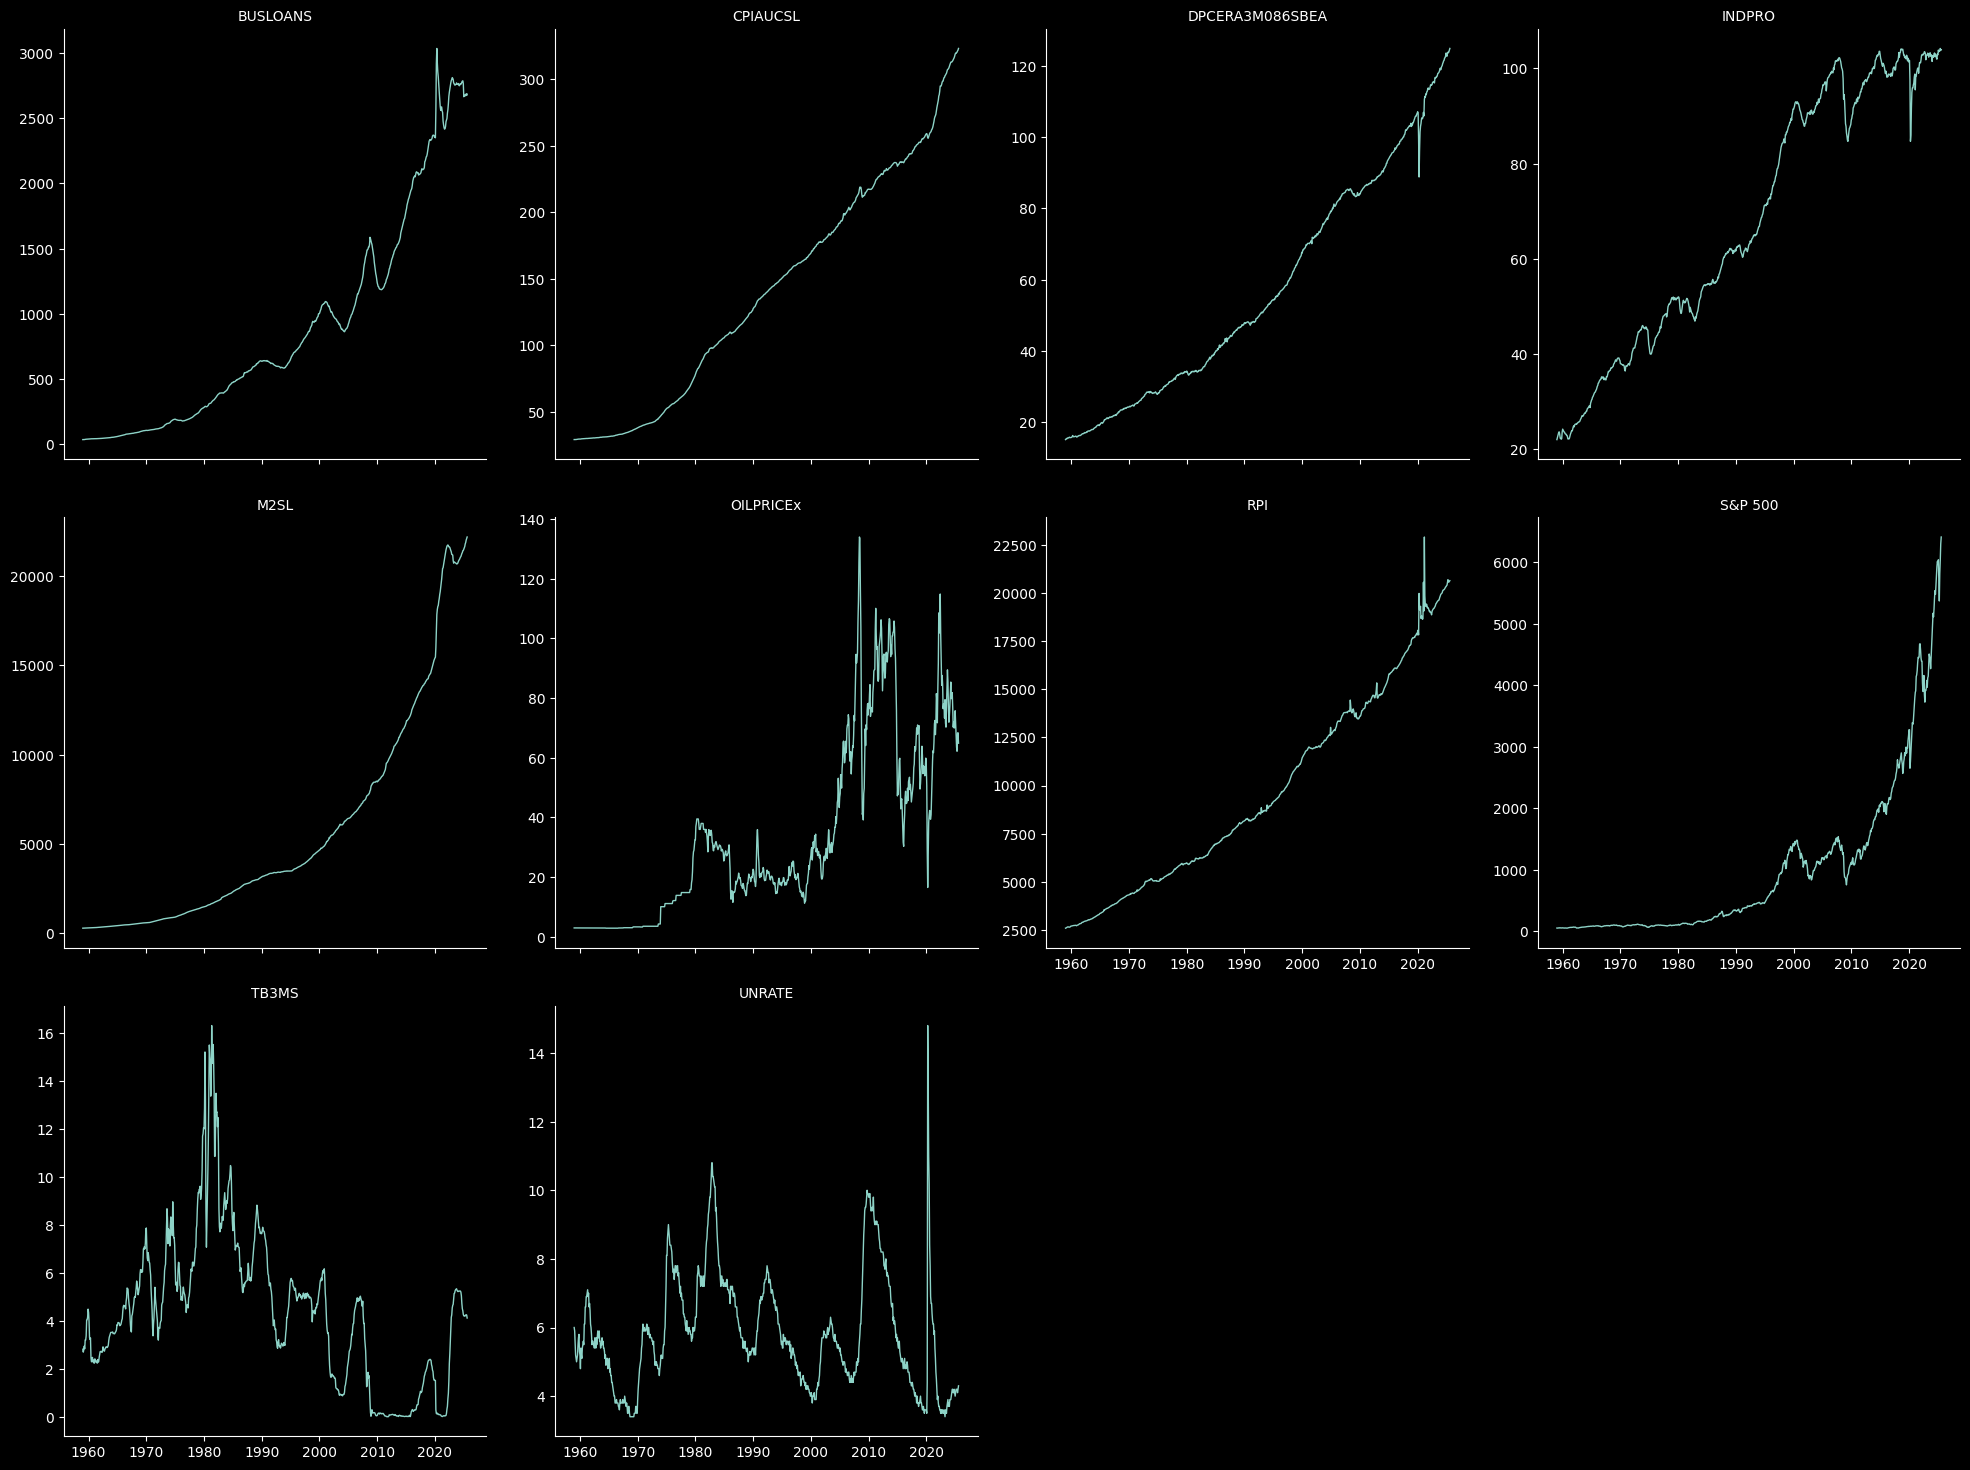

In [14]:
plt.style.use("dark_background")

g = sns.relplot(
    data=df_long,
    x="date", y="value",
    col="series", col_wrap=4,
    kind="line", linewidth=1,
    facet_kws=dict(sharey=False),
    hue=None, legend=False
)

g.set_axis_labels("", "")
g.set_titles("{col_name}")

for ax in g.axes.flat:
    ax.tick_params(axis="x", labelrotation=0, colors="white")
    ax.tick_params(axis="y", colors="white")
    ax.grid(False) 

plt.show()

Vu que le taux de chômage et le monthly treasure bill rate sont en pourcentage, ils sont très proche de l'état stationnaire (moyenne = 0  et variance stable). Le monthly treasure bill est un peu volatile. La variance commence à bouger sur l'OIL price tandis que la tendance à la hausse est la règle pour le reste. En clair, il faut analyser la stationnarité des données.

# 5.Stationnarité et son origine

In [15]:
# === 1) Test ADF (tau3) : racine unitaire ===
def test_adf_trend(series, autolag="AIC"):
    y = pd.Series(series).dropna()
    adf_res = adfuller(y, regression="ct", autolag=autolag)
    return {
        "adf_stat": adf_res[0],
        "adf_pval": adf_res[1],
        "usedlag": adf_res[2]
    }

In [16]:
ALPHA = 0.05
# === Helpers pour choix du lag de diff ===
def diff_l(series, l):
    """Δ_l y_t = y_t - y_{t-l}"""
    s = pd.Series(series)
    return s - s.shift(l)

def adf_ct_pval(x, autolag="AIC"):
    y = pd.Series(x).dropna()
    if len(y) < 20:
        return np.nan, None
    stat, pval, usedlag, *_ = adfuller(y, regression="ct", autolag=autolag)
    return pval, usedlag

def find_opt_diff_lag(series, candidates=(1,3,6,12), alpha=ALPHA, autolag="AIC"):
    details = {}
    best_l, best_p = None, np.inf
    for l in candidates:
        dy = diff_l(series, l)
        pval, usedlag = adf_ct_pval(dy, autolag=autolag)
        details[l] = {"pval": pval, "usedlag": usedlag}
        if pval is not None and not np.isnan(pval):
            if pval < best_p:
                best_p, best_l = pval, l
    passing = [l for l, d in details.items() if d["pval"] is not None and d["pval"] < alpha]
    opt_lag = min(passing) if passing else None
    return opt_lag, details, best_l

In [17]:
# === 2) Modèle 1 : Δy_t = c + β1 t + γ y_{t-1} + ... ===
def estimate_model1(series, lags):
    y = pd.Series(series).dropna()
    dy = y.diff()
    y_lag = y.shift(1)
    trend = np.arange(1, len(y) + 1)

    X = pd.DataFrame({"const": 1.0, "trend": trend, "y_lag": y_lag}, index=y.index)

    # Ajouter les retards de Δy
    for i in range(1, lags + 1):
        X[f"dy_lag{i}"] = dy.shift(i)

    df_model = pd.concat([dy, X], axis=1).dropna()
    dy_aligned = df_model.iloc[:, 0]
    X_aligned = df_model.iloc[:, 1:]
    ols_res = sm.OLS(dy_aligned, X_aligned).fit()
    return ols_res

In [18]:
# === 3) Test de Fisher (φ2) : H0 : c = β1 = γ = 0 ===
def test_fisher_phi2(ols_res):
    f_test = ols_res.f_test("const = 0, trend = 0, y_lag = 0")
    return {"phi2_F": float(f_test.fvalue), "phi2_pval": float(f_test.pvalue)}

In [19]:
# === 4) Analyse d'une série ===
def analyse_series(series, name, alpha=ALPHA):
    adf_out = test_adf_trend(series)
    ols_res = estimate_model1(series, adf_out["usedlag"])

    # Chercher un l optimal pour Δ_l y_t
    opt_lag, opt_scan, best_l = find_opt_diff_lag(series, candidates=(1,3,6,12), alpha=alpha)

    results = {
        "ADF stat (tau3)": adf_out["adf_stat"],
        "ADF p-value": adf_out["adf_pval"],
        "lags used (ADF)": adf_out["usedlag"],
        "beta1": ols_res.params.get("trend", np.nan),
        "beta1 p-value": ols_res.pvalues.get("trend", np.nan),
        "opt_diff_lag": opt_lag,   # lag minimal qui stationnarise Δ_l y_t
        "best_diff_lag": best_l,   # lag avec p-value ADF minimale
        "scan_pvals": {l: d["pval"] for l, d in opt_scan.items()}
    }

    # Décision finale (sur y_t brut)
    if adf_out["adf_pval"] < alpha:
        if results["beta1 p-value"] < alpha:
            results["Conclusion"] = "Stationnaire autour d’une tendance (TS)"
        else:
            results["Conclusion"] = "Stationnaire sans tendance significative"
    else:
        fisher_out = test_fisher_phi2(ols_res)
        results.update(fisher_out)
        if fisher_out["phi2_pval"] < alpha:
            results["Conclusion"] = "Δy_t est TS, donc y_t est I(1)"
        else:
            results["Conclusion"] = "y_t est une marche aléatoire pure (RW)"
    return results

In [20]:
# === 5) Application au DataFrame → tableau large (lignes = variables, colonnes = tests) ===
def analyse_dataframe(df):
    rows = {}
    for col in df.columns:
        rows[col] = analyse_series(df[col], col)
    return pd.DataFrame(rows).T

# --- Exécution ---
summary = analyse_dataframe(df)

# Lags à afficher en colonnes
LAGS_VIEW = [1, 3, 6, 12]

# Construire colonnes Δ_l (p-values + indicateur stationnarité)
scan_cols = {f"ADF p(Δ{l})": [] for l in LAGS_VIEW}
scan_cols.update({f"Stat Δ{l} (p<{ALPHA})": [] for l in LAGS_VIEW})

index_vals = []
for serie, res in summary.iterrows():
    index_vals.append(serie)
    scan = res.get("scan_pvals", {}) or {}
    for l in LAGS_VIEW:
        p = scan.get(l, np.nan)
        scan_cols[f"ADF p(Δ{l})"].append(p)
        if p is None or (isinstance(p, float) and np.isnan(p)):
            scan_cols[f"Stat Δ{l} (p<{ALPHA})"].append(np.nan)
        else:
            scan_cols[f"Stat Δ{l} (p<{ALPHA})"].append(bool(p < ALPHA))

df_scan_wide = pd.DataFrame(scan_cols, index=index_vals)

# Combiner avec le résumé niveau (en retirant la colonne scan_pvals brute)
base_cols = [c for c in summary.columns if c != "scan_pvals"]
df_wide = pd.concat([summary[base_cols], df_scan_wide], axis=1)

# Ordonner les colonnes principales
ordered = [
    "ADF stat (tau3)", "ADF p-value", "beta1", "beta1 p-value",
    "phi2_F", "phi2_pval", "Conclusion",
    "opt_diff_lag", "best_diff_lag",
] + [f"ADF p(Δ{l})" for l in LAGS_VIEW] + [f"Stat Δ{l} (p<{ALPHA})" for l in LAGS_VIEW]
ordered = [c for c in ordered if c in df_wide.columns]

# Affichage propre (toutes colonnes)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 200, 'display.max_colwidth', None):
    print(df_wide.reindex(columns=ordered))

                ADF stat (tau3) ADF p-value     beta1 beta1 p-value     phi2_F phi2_pval                                Conclusion opt_diff_lag best_diff_lag     ADF p(Δ1)     ADF p(Δ3)  \
UNRATE                -3.440606    0.046194 -0.000028      0.668239        NaN       NaN  Stationnaire sans tendance significative            1             1  1.362925e-22  1.268912e-06   
TB3MS                 -2.980016    0.137754 -0.000121      0.064486   2.996165   0.03008            Δy_t est TS, donc y_t est I(1)            1            12  2.545625e-07  6.965768e-07   
RPI                   -0.458905    0.984961  0.162572      0.305725   12.16733       0.0            Δy_t est TS, donc y_t est I(1)            1             3  2.171676e-10  5.731398e-11   
INDPRO                -2.318422    0.423788  0.001184      0.031527   4.229567  0.005602            Δy_t est TS, donc y_t est I(1)            1             1  8.402623e-10  1.821815e-08   
DPCERA3M086SBEA       -0.457154    0.985022  0.000602  

## Analyse de la stationnarité : 
On comprend mieux maintenant nos données. Le taux de chômage est stationnaire à niveau. C'est normal puisque c'est un taux. Le reste ne sont pas stationnaires.
Presque toutes les séries sont stationnaires avec une différenciation 1. Seul le prix du baril du pétrol qui est stationnaire autour d'une tendance.

La différenciation d'ordre 1 ne signifie pas que le nombre de lag optimal est égal à 1. Nous pouvons encore appliquer un lag = 1, 3, 6, 12 mais avec une seule différenciation.

# Que faire? 
1. Cible (UNRATE)
- Objectif : prédire la variation annuelle du chômage.
- Transformation : Δ12 UNRATE (même si stationnaire en niveau).
- Justification : cohérent avec l’horizon de prévision (12 mois).

2. Variables explicatives
- TB3MS (taux d’intérêt) : Δ3 niveau.
→ Les taux ne se loggent pas ; variation trimestrielle en points.
RPI, INDPRO, Consommation, BUSLOANS, CPI, M2 : Δ3 log.
→ Taux de croissance trimestriels, stationnarité assurée, moins bruités que Δ1.
S&P 500, Oil : Δ3 log.
→ Séries volatiles, Δ3 lisse le bruit tout en gardant du signal.

3. Pourquoi Δ3 pour les prédicteurs ?
- Stationnarité garantie.
- Compromis bruit / signal : Δ1 trop volatil, Δ12 trop lent.
- Pertinence économique : capte des signaux trimestriels anticipant l’évolution annuelle du chômage.
- et surtout recommandé dans la base FRED-MD (McCracken & Ng, 2016) pour la plupart des séries.

Résumé :
- Target : Δ12 UNRATE.
- Features : Δ3 (niveau pour TB3MS, log-diff pour les autres).

# Stationnarisation

In [21]:
# ========= 1) Petites fonctions de base =========

def diff_simple(series: pd.Series, lags: int) -> pd.Series:
    """Δ_l x_t = x_t - x_{t-l}"""
    s = pd.Series(series).astype(float)
    return s.diff(lags)

In [22]:
def log_diff(series: pd.Series, lags: int) -> pd.Series:
    """Δ_l log(x_t) ; met à NaN les valeurs non-positives avant log."""
    s = pd.Series(series).astype(float)
    s = s.where(s > 0)
    return np.log(s).diff(lags)

In [23]:
def adf_test(series: pd.Series, alpha: float = 0.05, regression: str = "ct", autolag: str = "AIC") -> dict:
    """Wrapper ADF (statsmodels). Retourne dict standardisé."""
    y = pd.Series(series).astype(float).replace([np.inf, -np.inf], np.nan).dropna()
    if len(y) < 20:
        return {"ok": False, "reason": "insufficient_data", "nobs": len(y)}
    stat, pval, usedlag, nobs, crit, icbest = adfuller(y, regression=regression, autolag=autolag)
    return {
        "ok": True, "stat": float(stat), "pval": float(pval),
        "lags": int(usedlag), "nobs": int(nobs), "crit": crit,
        "stationary": (pval < alpha)
    }

In [178]:
# ========= 2) Fonctions “règles” et transformation d’une série =========

In [24]:
def choose_rule(col_name: str, rules: dict) -> dict:
    """Retourne la règle à appliquer pour une colonne."""
    return rules.get(col_name, rules["_default"])

In [25]:
def apply_transform_one(col_name: str, series: pd.Series, rules: dict) -> tuple[pd.Series, str, int, str]:
    """
    Applique la règle à UNE série.
    Retourne: (série transformée, label lisible, lags, method)
    """
    rule = choose_rule(col_name, rules)
    method, lags = rule["method"], int(rule["lags"])

    if method == "diff":
        y = diff_simple(series, lags)
        label = f"Δ{lags}"
    elif method == "logdiff":
        y = log_diff(series, lags)
        label = f"Δlog (lag={lags})"
    else:
        raise ValueError(f"Méthode inconnue: {method}")

    return y, label, lags, method

In [26]:
def adf_summary_one(col_name: str, series_trans: pd.Series, alpha: float, regression: str) -> dict:
    """Exécute l’ADF sur UNE série transformée et fabrique une ligne de résumé."""
    res = adf_test(series_trans, alpha=alpha, regression=regression)
    if res.get("ok", False):
        return {
            "series": col_name,
            "ADF stat": res["stat"],
            "p-value": res["pval"],
            "usedlag(ADF)": res["lags"],
            "nobs": res["nobs"],
            "verdict": "Stationary" if res["stationary"] else "Non-stationary",
        }
    else:
        return {
            "series": col_name,
            "ADF stat": np.nan,
            "p-value": np.nan,
            "usedlag(ADF)": np.nan,
            "nobs": res.get("nobs", np.nan),
            "verdict": res.get("reason", "error"),
        }

In [27]:
# ========= 3) Fonction maître : traite tout le DataFrame =========

def transform_all_series(
    df: pd.DataFrame,
    columns: list[str] | None = None,
    *,
    rules: dict | None = None,
    alpha: float = 0.05,
    adf_regression: str = "ct",
    dropna_all: bool = True,
) -> tuple[pd.DataFrame, pd.DataFrame, dict]:
    """
    Orchestration complète :
      - applique la règle série par série,
      - aligne et nettoie,
      - lance ADF,
      - retourne (df_trans, summary_adf, meta).

    Params clés:
      rules: dictionnaire de règles (sinon DEFAULT_RULES)
      adf_regression: "ct" (constante+tendance) | "c" (constante) | "nc"
      dropna_all: si True, on supprime les lignes avec NaN sur *n’importe* quelle série
                  (alignement strict). Sinon, on ne touche pas aux NaN.
    """
    if rules is None:
        rules = DEFAULT_RULES

    if columns is None:
        columns = list(df.columns)

    df_trans = pd.DataFrame(index=df.index)
    meta = {}
    rows = []

    for col in columns:
        if col not in df.columns:
            continue
        y, label, lags, method = apply_transform_one(col, df[col], rules)
        df_trans[col] = y
        meta[col] = {"label": label, "lags": lags, "method": method}

        rows.append(adf_summary_one(col, y, alpha=alpha, regression=adf_regression))

    if dropna_all:
        df_trans = df_trans.replace([np.inf, -np.inf], np.nan).dropna(how="any")

    summary_adf = pd.DataFrame(rows).set_index("series").sort_index()
    return df_trans, summary_adf, meta

In [28]:
# === appel ===

rules = {
    "UNRATE":   {"method": "diff",    "lags": 12},  # chômage Δ12
    "TB3MS":    {"method": "diff",    "lags": 3},   # T-bill Δ3
    "_default": {"method": "logdiff", "lags": 3},   # autres Δlog(3)
}

df_trans, summary_adf, meta = transform_all_series(
    df,
    rules=rules,
    alpha=0.05,
    adf_regression="ct"
)

# Construire un DataFrame combiné
results_df = summary_adf.copy()
results_df["method"] = [meta[s]["label"] for s in results_df.index]
results_df["status"] = np.where(
    results_df["verdict"].eq("Stationary"),
    "✅ Stationary",
    "❌ Non-stationary"
)

# Réorganiser les colonnes
results_df = results_df[["method", "ADF stat", "p-value", "usedlag(ADF)", "nobs", "status"]]

print("\n=== Résultats Stationnarité (DataFrame unique) ===")
print(results_df)

# Si besoin : export complet
# results_df.to_csv("stationarity_results.csv")


=== Résultats Stationnarité (DataFrame unique) ===
                       method  ADF stat       p-value  usedlag(ADF)  nobs  \
series                                                                      
BUSLOANS         Δlog (lag=3) -5.265635  6.574716e-05            20   776   
CPIAUCSL         Δlog (lag=3) -3.605395  2.939308e-02            20   776   
DPCERA3M086SBEA  Δlog (lag=3) -5.828412  5.001033e-06            18   778   
INDPRO           Δlog (lag=3) -6.799566  3.993837e-08            21   775   
M2SL             Δlog (lag=3) -5.265924  6.566398e-05            19   777   
OILPRICEx        Δlog (lag=3) -6.084496  1.457009e-06            21   775   
RPI              Δlog (lag=3) -7.250088  3.813889e-09            20   776   
S&P 500          Δlog (lag=3) -6.224656  7.317670e-07            21   775   
TB3MS                      Δ3 -6.234617  6.965768e-07            21   775   
UNRATE                    Δ12 -5.659811  1.104609e-05            13   774   

                       

In [29]:
df_trans.head()

,UNRATE,TB3MS,RPI,INDPRO,DPCERA3M086SBEA,S&P 500,BUSLOANS,CPIAUCSL,OILPRICEx,M2SL
date,,,,,,,,,,
1960-01-01,-0.8,0.30,0.020977,0.091980,0.001204,0.017909,0.031212,0.000681,0.0,0.005717
1960-02-01,-1.1,-0.19,0.014565,0.076964,0.006009,-0.025663,0.027763,0.002042,0.0,0.004366
1960-03-01,-0.2,-1.18,0.006250,0.007961,0.021240,-0.070857,0.018278,0.000000,0.0,0.005024
1960-04-01,0.0,-1.12,0.006489,-0.025915,0.033752,-0.040442,0.022114,0.005772,0.0,0.006351
1960-05-01,0.0,-0.67,0.007747,-0.018121,0.009040,-0.010090,0.027404,0.005426,0.0,0.008343


In [30]:
df_stationary = df_trans

# Analyse del'autocorrélation

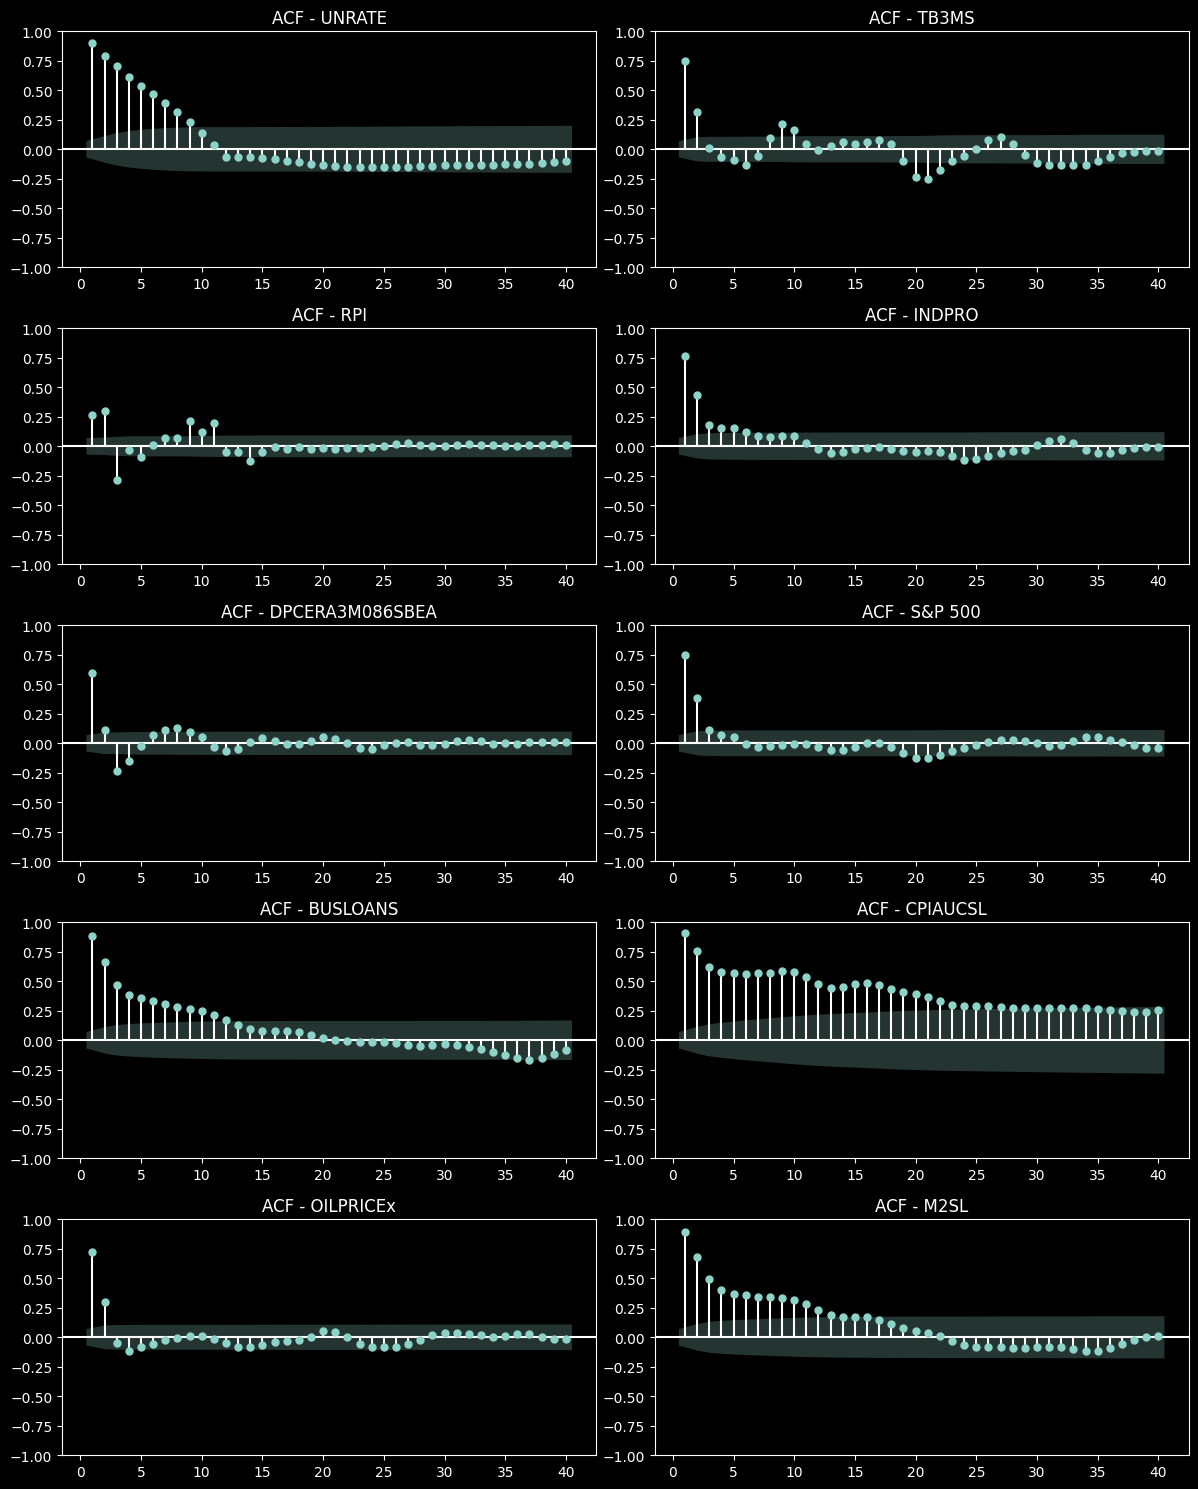

In [31]:
# Supposons que df_stationary = ton DataFrame des séries déjà transformées
n_cols = 2
n_rows = int(np.ceil(len(df_stationary.columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3*n_rows))

for ax, col in zip(axes.flatten(), df_stationary.columns):
    plot_acf(df_stationary[col].dropna(), lags=40, ax=ax, zero=False)
    ax.set_title(f"ACF - {col}")

# Masquer les sous-graphiques vides s'il y en a
for ax in axes.flatten()[len(df_stationary.columns):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

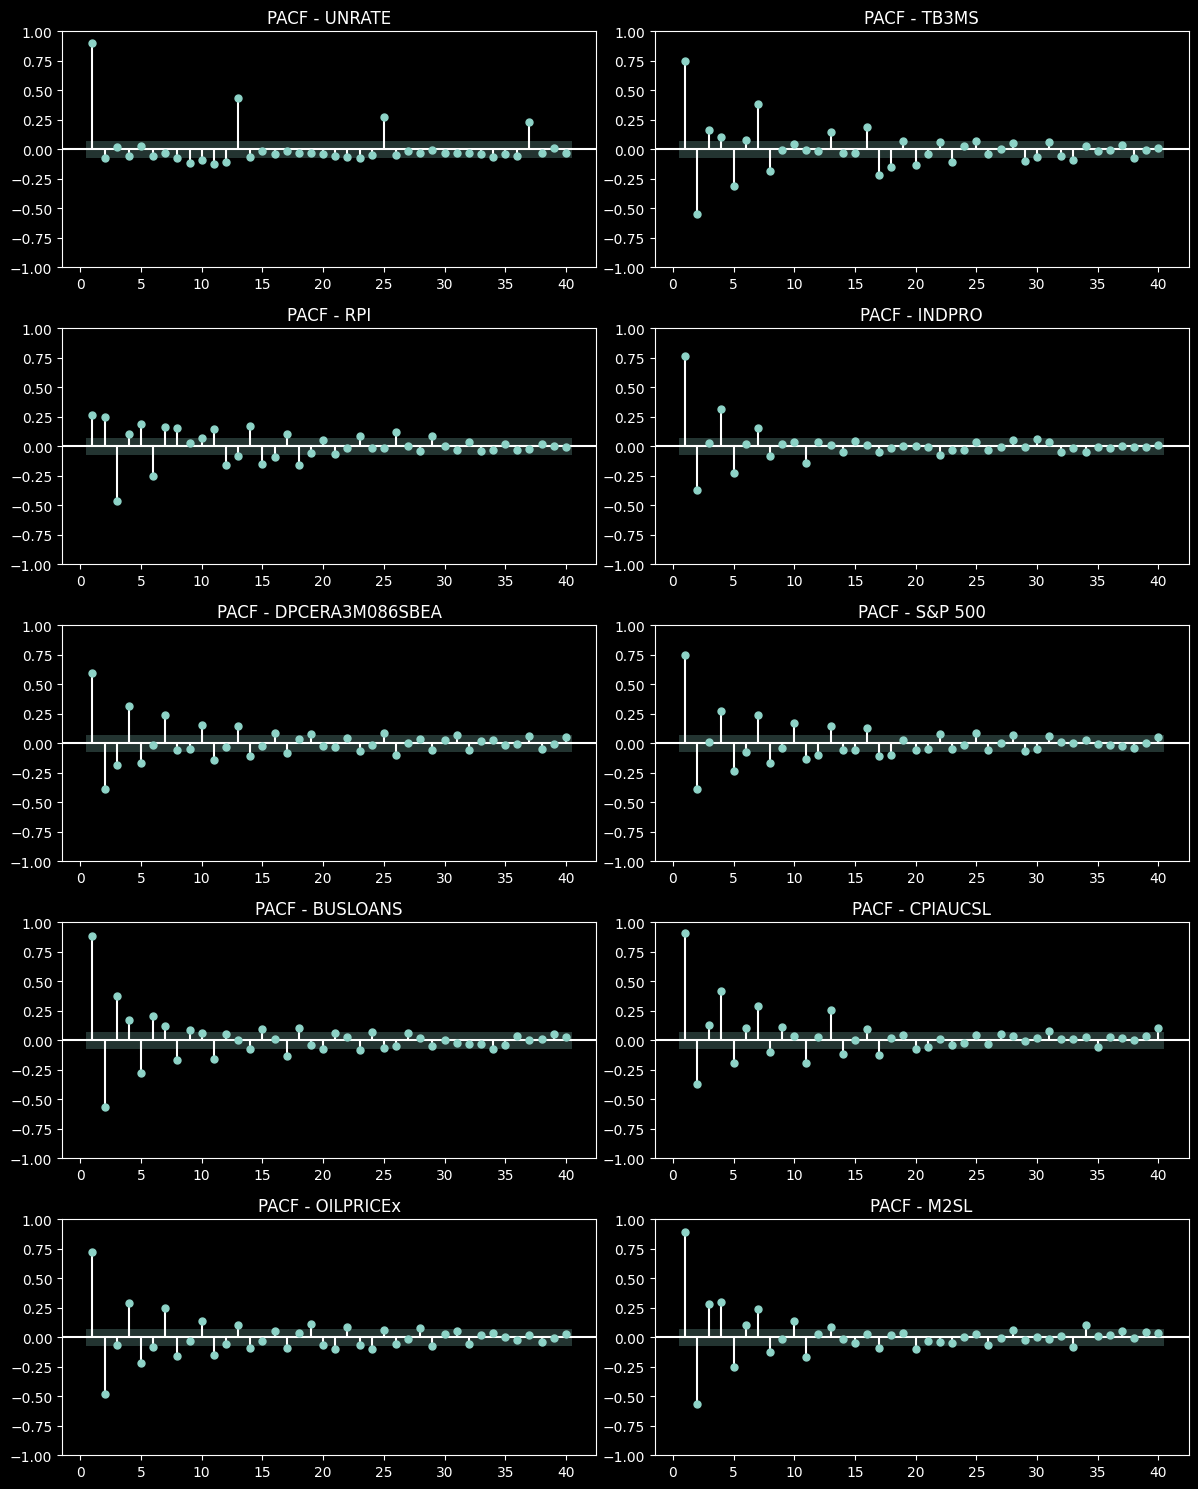

In [32]:
# Supposons que df_stationary = ton DataFrame des séries déjà transformées
n_cols = 2
n_rows = int(np.ceil(len(df_stationary.columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3*n_rows))

for ax, col in zip(axes.flatten(), df_stationary.columns):
    plot_pacf(df_stationary[col].dropna(), lags=40, ax=ax, zero=False)
    ax.set_title(f"PACF - {col}")

# Masquer les sous-graphiques vides s'il y en a
for ax in axes.flatten()[len(df_stationary.columns):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

# ACF au carré

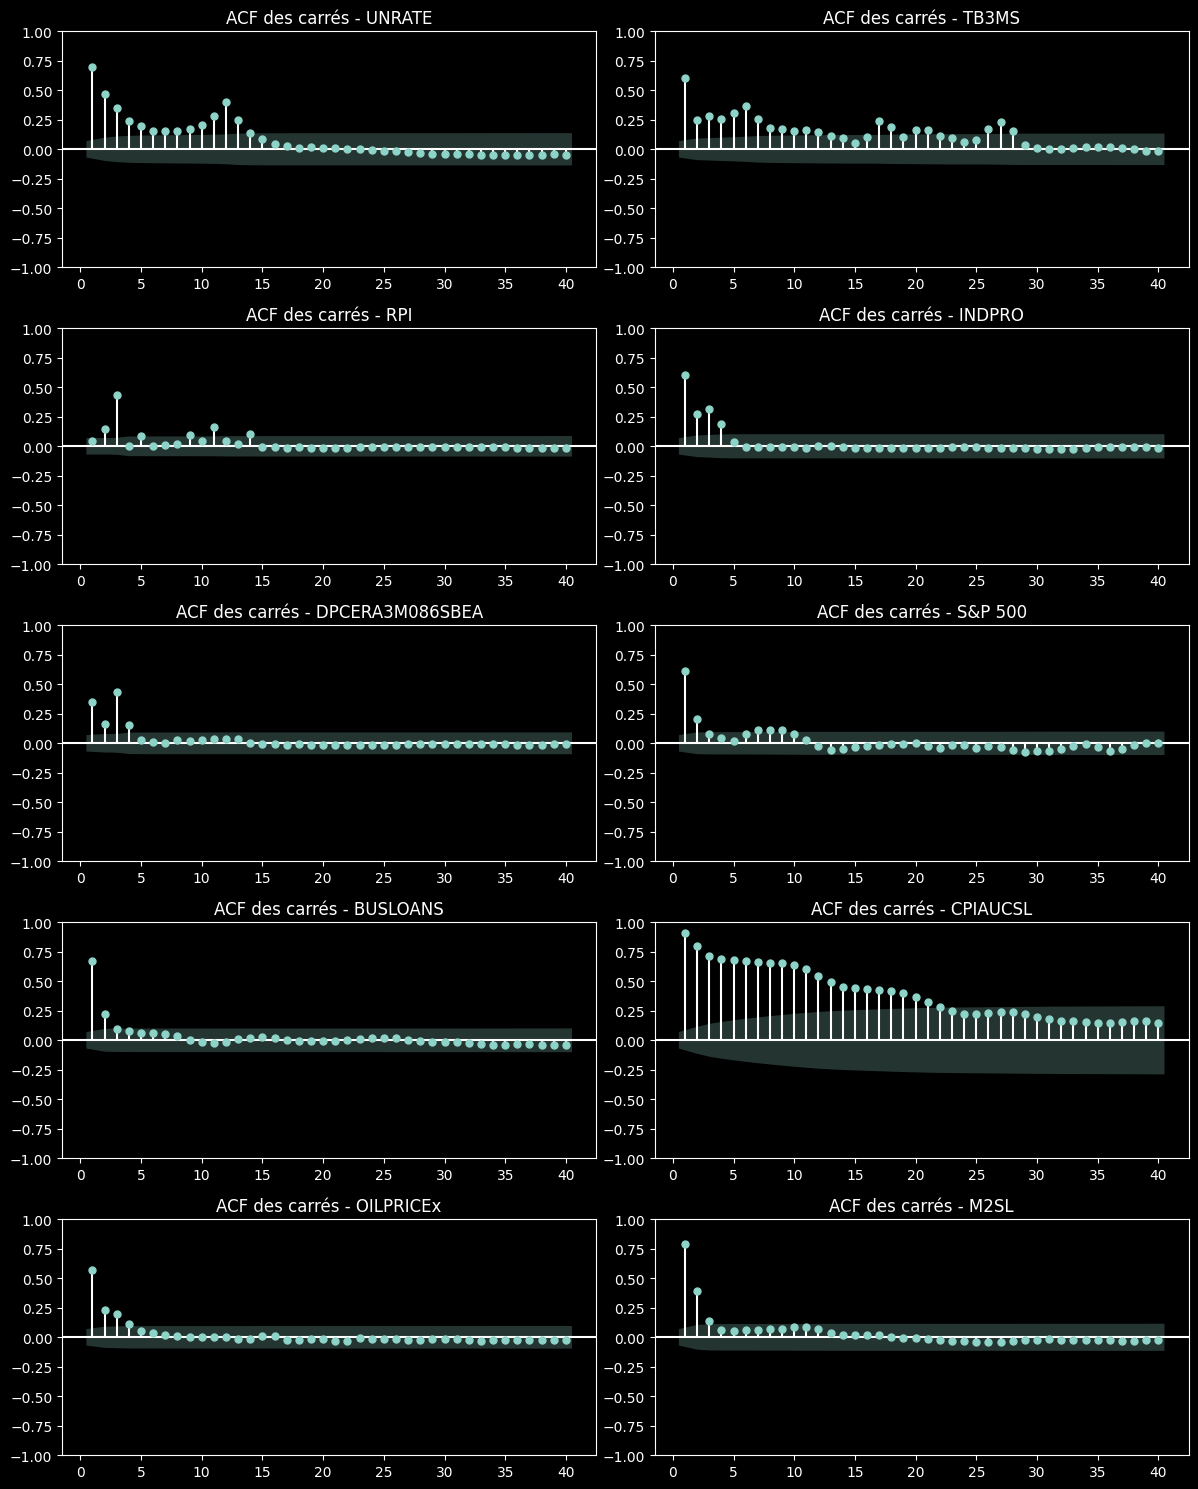

In [33]:
# Supposons que df_stationary = ton DataFrame des séries déjà stationnaires
n_cols = 2
n_rows = int(np.ceil(len(df_stationary.columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3*n_rows))

for ax, col in zip(axes.flatten(), df_stationary.columns):
    # Ici on élève la série au carré
    squared_series = df_stationary[col].dropna() ** 2
    
    plot_acf(squared_series, lags=40, ax=ax, zero=False)
    ax.set_title(f"ACF des carrés - {col}")

# Masquer les sous-graphiques vides s'il y en a
for ax in axes.flatten()[len(df_stationary.columns):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

# Analyse de la volatilité des predicators

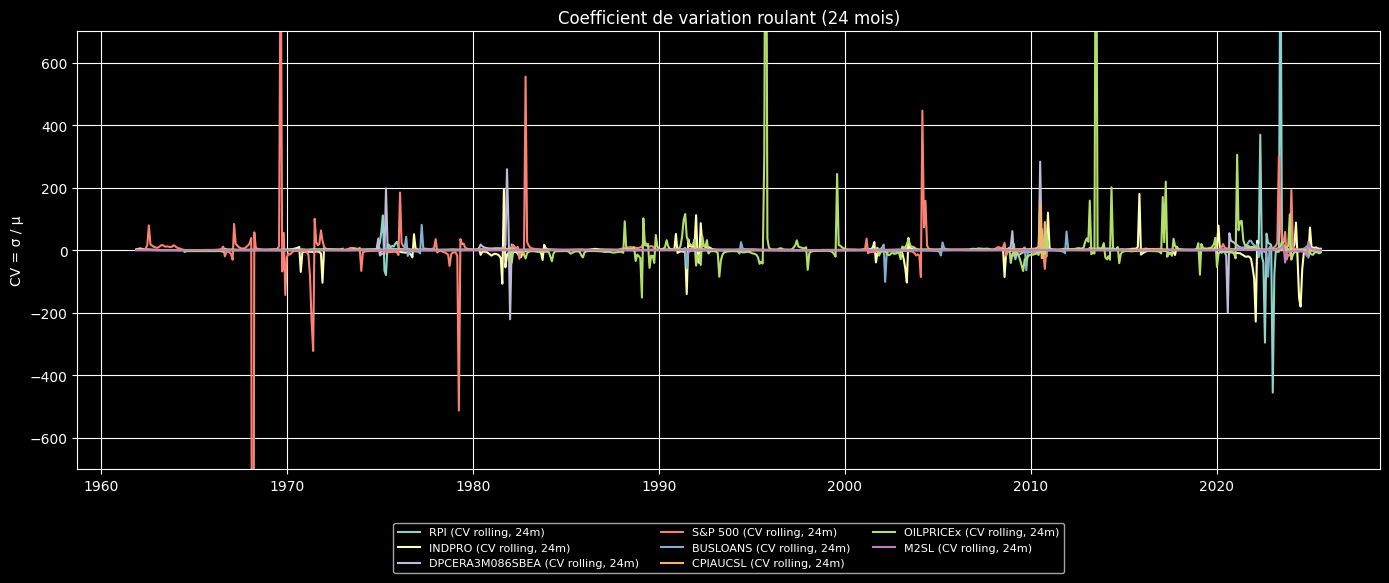

In [34]:
WINDOW = 24

# Sélection des colonnes (toutes sauf UNRATE et TB3MS)
cols = [c for c in df_stationary.columns if c not in ["UNRATE", "TB3MS"]]

# Rolling mean et std
roll_mean_sel = df_stationary[cols].rolling(window=WINDOW).mean()
roll_std_sel = df_stationary[cols].rolling(window=WINDOW).std()

# Coefficient de variation roulant
roll_cv_sel = roll_std_sel / roll_mean_sel

# --- Affichage graphique ---
plt.figure(figsize=(14,6))
for col in cols:
    plt.plot(roll_cv_sel[col], label=f"{col} (CV rolling, 24m)")

plt.title("Coefficient de variation roulant (24 mois)")
plt.ylabel("CV = σ / μ")

# Limiter l'axe Y
plt.ylim(-700, 700)

# Légende en bas, plus petite
plt.legend(
    loc="lower center", 
    fontsize=8, 
    ncol=3, 
    bbox_to_anchor=(0.5, -0.25)  # Décalage vers le bas
)

plt.grid(True)
plt.tight_layout()
plt.show()

Pourquoi certaines séries nécessitent une différenciation d’ordre 2 ?
Séries à tendance persistante (BUSLOANS, CPIAUCSL, M2SL) :
→ Δlog enlève la tendance moyenne, mais la persistance reste forte.
→ Δ²log supprime la mémoire longue → stationnarité.

Séries instables (OILPRICEx, partiellement S&P 500) :
→ Pas de tendance lisse mais variance explosive (chocs pétroliers, crises).
→ Δ²log réduit l’instabilité → stationnarité.

Séries cycliques (UNRATE, TB3MS) :
→ Pas de croissance régulière, plutôt cycles.
→ Δ simple (lags 12 ou 3) suffit.

📌 Résumé :
Δ²log : tendance persistante ou forte instabilité.
Δ (ordre 1) : séries cycliques (taux, chômage).

# Différenciation de second ordre

In [35]:
# --- Δ²log avec lag=3 ---
def d2log(series, l=3):
    s = pd.Series(series).astype(float)
    s = s.where(s > 0)           # log sûr (ignore <= 0)
    return np.log(s).diff(l).diff(l)

# + OILPRICEx (ajuste le nom si différent chez toi)
cols_d2log = ["BUSLOANS", "CPIAUCSL", "M2SL", "OILPRICEx"]
cols_d2log = [c for c in cols_d2log if c in df.columns]

# 1) Transformer
df_d2 = pd.DataFrame({c: d2log(df[c], l=3) for c in cols_d2log})
df_d2 = df_d2.dropna(how="any")

print("=== Δ²log (lag=3) — premières lignes ===")
print(df_d2.head())

# 2) Vérifier ADF (constante seule, adapté à des séries déjà différenciées)
rows = []
for c in df_d2.columns:
    y = df_d2[c].replace([np.inf, -np.inf], np.nan).dropna()
    stat, pval, usedlag, nobs, *_ = adfuller(y, regression="c", autolag="AIC")
    rows.append({"series": c, "ADF stat": stat, "p-value": pval, "lags(ADF)": usedlag, "nobs": nobs,
                 "verdict": "Stationary" if pval < 0.05 else "Non-stationary"})
summary_d2 = pd.DataFrame(rows).set_index("series").sort_index()

print("\n=== Résumé ADF (Δ²log, lag=3) ===")
print(summary_d2)

=== Δ²log (lag=3) — premières lignes ===
            BUSLOANS  CPIAUCSL      M2SL  OILPRICEx
date                                               
1959-07-01  0.047797  0.006884  0.005289    0.01005
1959-08-01  0.017554  0.003431 -0.001249    0.01005
1959-09-01 -0.025926 -0.000023 -0.008000    0.00000
1959-10-01 -0.037916  0.000989 -0.013033    0.00000
1959-11-01 -0.032074  0.001000 -0.011913    0.00000

=== Résumé ADF (Δ²log, lag=3) ===
           ADF stat       p-value  lags(ADF)  nobs     verdict
series                                                        
BUSLOANS  -7.132520  3.487916e-10         21   772  Stationary
CPIAUCSL  -5.869776  3.260849e-07         21   772  Stationary
M2SL      -7.388155  8.133021e-11         19   774  Stationary
OILPRICEx -8.250778  5.398469e-13         21   772  Stationary


# Combinaison des données

In [36]:

# --- 1) Helper: Δ² log avec fenêtre l ---
def d2log(series: pd.Series, l: int = 3, eps: float = 1e-6) -> pd.Series:
    s = pd.Series(series, dtype=float)
    s = s.clip(lower=eps)                # évite log(0) et négatifs
    return np.log(s).diff(l).diff(l)     # Δ_l^2 log

# --- 2) Colonnes à transformer (seulement celles présentes) ---
cols_d2log = [c for c in ["BUSLOANS", "CPIAUCSL", "M2SL", "OILPRICEx"] if c in df.columns]

# --- 3) Appliquer Δ²log(l=3) sur df brut et ALIGNER sur l'index de df_stationary ---
df_d2 = pd.DataFrame({c: d2log(df[c], l=3) for c in cols_d2log})
# Aligner pour garantir la correspondance d'index (important pour update)
df_d2 = df_d2.reindex(df_stationary.index)

# --- 4) Mettre à jour df_stationary avec les colonnes Δ²log ---
df_stationary = df_stationary.copy()
df_stationary.update(df_d2)              # remplace seulement les colonnes ciblées

# --- 5) Nettoyage minimal et non destructif ---
# Remplacer inf/ninf par NaN
df_stationary.replace([np.inf, -np.inf], np.nan, inplace=True)
# Ne dropper que si NaN dans les colonnes modifiées (évite de perdre d'autres séries)
if cols_d2log:
    df_stationary = df_stationary.dropna(subset=cols_d2log)

# --- 6) (Optionnel mais recommandé) Mettre à jour summary_all pour refléter d=2 ---
if "summary_all" in globals():
    summary_all = summary_all.copy()
    # Si l'index de summary_all est 'series', on met à jour directement
    # Sinon, essaye d'abord de le remettre avec 'series' en index si besoin
    if "series" in summary_all.columns and not summary_all.index.name == "series":
        summary_all = summary_all.set_index("series")

    mask = summary_all.index.isin(cols_d2log)
    if mask.any():
        summary_all.loc[mask, "method"] = "Δ² log (l=3)"
        summary_all.loc[mask, "order"]  = 2
        # s'assurer de l'entier
        try:
            summary_all["order"] = summary_all["order"].astype(int)
        except Exception:
            pass

# --- 7) ADF + KPSS sur les colonnes modifiées ---
rows = []
for c in cols_d2log:
    y = df_stationary[c].dropna()
    if len(y) < 20:
        rows.append({"ADF p-value": np.nan, "KPSS p-value": np.nan, "Verdict": "Série trop courte"})
        continue
    adf_p = adfuller(y, regression="c", autolag="AIC")[1]
    kpss_stat, kpss_p, *_ = kpss(y, regression="c", nlags="auto")
    rows.append({
        "ADF p-value": adf_p,
        "KPSS p-value": kpss_p,
        "Verdict": "Stationnaire" if (adf_p < 0.05 and kpss_p > 0.05) else "À vérifier"
    })

summary = pd.DataFrame(rows, index=cols_d2log)
print(summary)

# --- 8) NOTE pour le melt plus tard ---
# Si tu fais ensuite un melt:
# - NE PAS attacher de DataFrame dans df_stationary.attrs (cela casse melt/concat).
# - Si tu avais déjà des attrs, fais: df_stationary = df_stationary.copy(); df_stationary.attrs.clear()

            ADF p-value  KPSS p-value       Verdict
BUSLOANS   4.267894e-10           0.1  Stationnaire
CPIAUCSL   3.721934e-07           0.1  Stationnaire
M2SL       9.985381e-11           0.1  Stationnaire
OILPRICEx  6.558137e-13           0.1  Stationnaire


C:\Users\Mita\AppData\Local\Temp\ipykernel_15720\973710328.py:52: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(y, regression="c", nlags="auto")
C:\Users\Mita\AppData\Local\Temp\ipykernel_15720\973710328.py:52: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(y, regression="c", nlags="auto")
C:\Users\Mita\AppData\Local\Temp\ipykernel_15720\973710328.py:52: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(y, regression="c", nlags="auto")
C:\Users\Mita\AppData\Local\Temp\ipykernel_15720\973710328.py:52: InterpolationWarning: The test statistic is

# Refaire l'analyse de l'autocorrélation

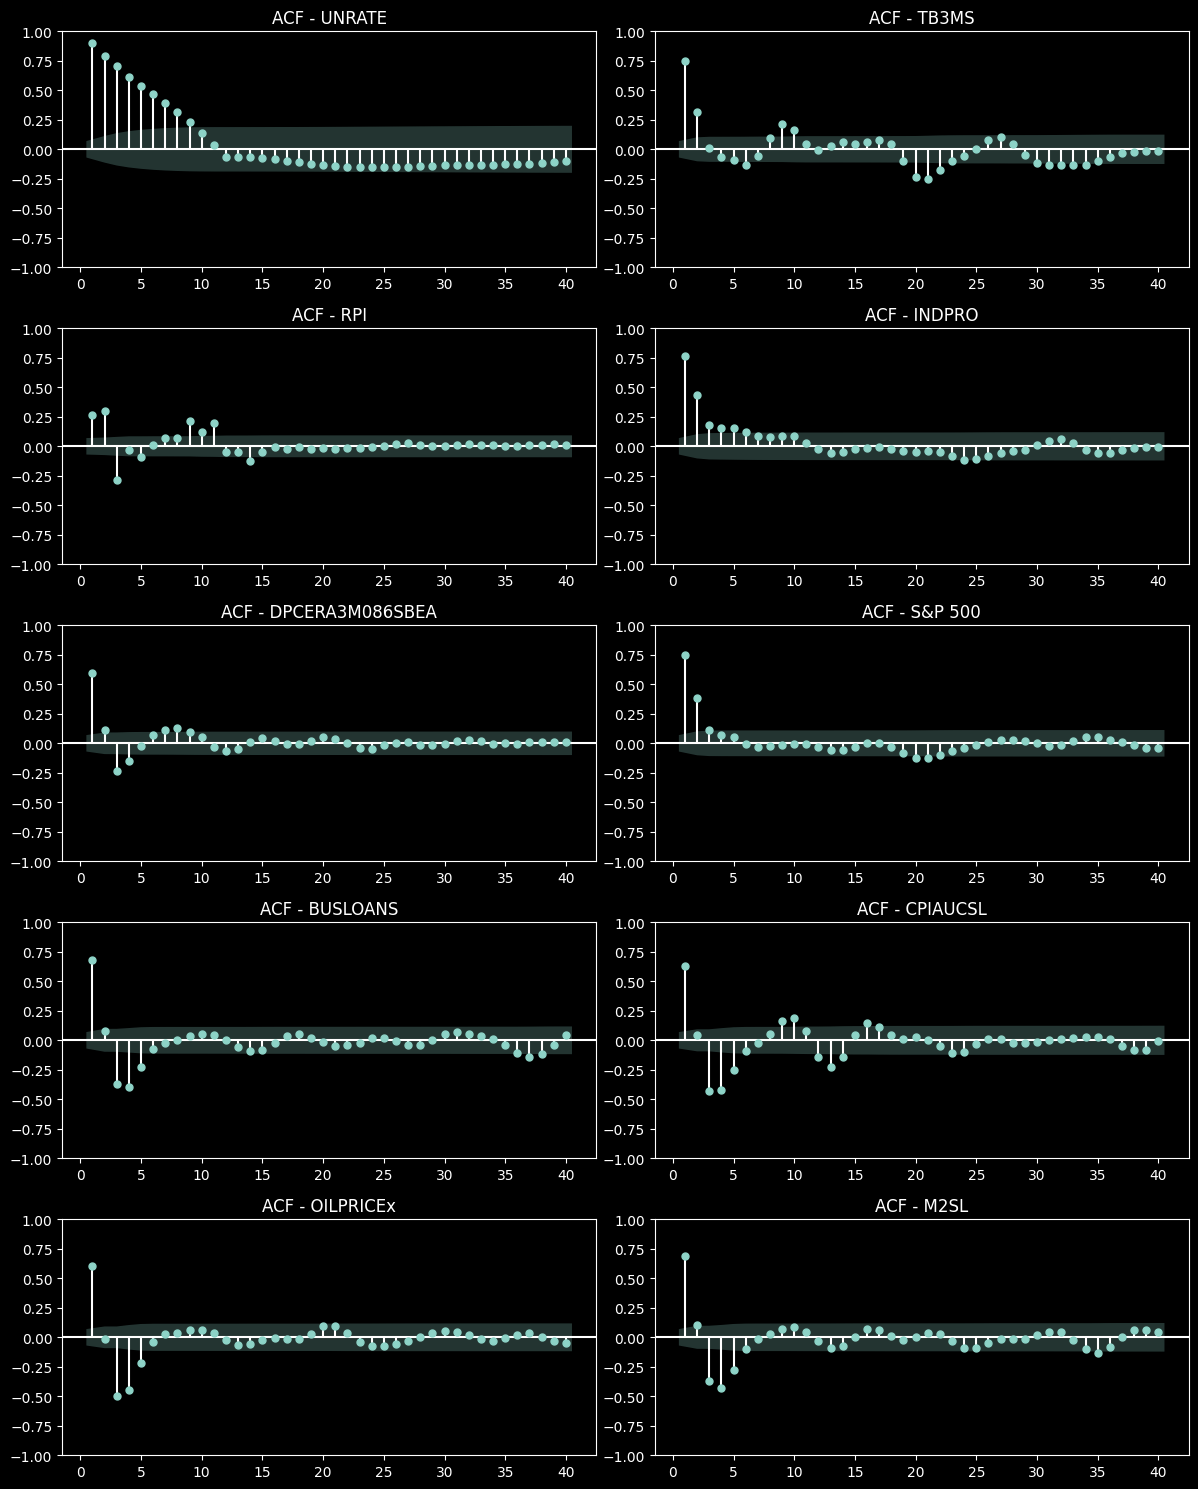

In [37]:
# 4) Tracer l’ACF pour TOUTES les séries stationnarisées (mise à jour)
n_cols = 2
n_rows = int(np.ceil(len(df_stationary.columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3*n_rows))

for ax, col in zip(axes.flatten(), df_stationary.columns):
    plot_acf(df_stationary[col].dropna(), lags=40, ax=ax, zero=False)
    ax.set_title(f"ACF - {col}")

# Masquer axes vides s'il y en a
for ax in axes.flatten()[len(df_stationary.columns):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

# Présenter graphiquement les séries temporelles stationnaires avec les indicateurs de récession

In [60]:
import pandas as pd
from pandas_datareader import data as web

# 1) Télécharger la série de récession USRECDM (FRED)
usrec = (
    web.DataReader("USRECDM", "fred", start="1959-01-01")
      .resample("M").max()
      .rename(columns={"USRECDM": "USREC"})
)
usrec.index = usrec.index.to_period("M").to_timestamp("M")
usrec["USREC"] = usrec["USREC"].astype("int8")

# Vérifier la répartition (optionnel)
print(pd.crosstab(index=usrec["USREC"], columns="count"))

# 2) Nettoyage des anciennes colonnes USREC_* s’il y en a
cols_to_drop = [c for c in df_stationary.columns if c.startswith("USREC")]
df_stationary = df_stationary.drop(columns=cols_to_drop, errors="ignore")

# 3) Harmoniser les index en fin de mois
df_stationary.index = pd.to_datetime(df_stationary.index)
df_stationary.index = df_stationary.index.to_period("M").to_timestamp("M")

# 4) Ajouter la série de récession alignée
df_stationary["USREC"] = usrec["USREC"].reindex(df_stationary.index)

col_0  count
USREC       
0        698
1        104


C:\Users\Mita\AppData\Local\Temp\ipykernel_15720\3695556997.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M").max()


In [61]:
# ✅ Résultat final : df_stationary propre et synchronisé
print(df_stationary.head())

            UNRATE  TB3MS       RPI    INDPRO  DPCERA3M086SBEA   S&P 500  \
date                                                                       
1960-01-31    -0.8   0.30  0.020977  0.091980         0.001204  0.017909   
1960-02-29    -1.1  -0.19  0.014565  0.076964         0.006009 -0.025663   
1960-03-31    -0.2  -1.18  0.006250  0.007961         0.021240 -0.070857   
1960-04-30     0.0  -1.12  0.006489 -0.025915         0.033752 -0.040442   
1960-05-31     0.0  -0.67  0.007747 -0.018121         0.009040 -0.010090   

            BUSLOANS  CPIAUCSL  OILPRICEx      M2SL  USREC  
date                                                        
1960-01-31  0.011578 -0.006156        0.0  0.001323      0  
1960-02-29  0.011905 -0.003767        0.0  0.002007      0  
1960-03-31 -0.008356 -0.005455        0.0  0.001324      0  
1960-04-30 -0.009098  0.005090        0.0  0.000634      1  
1960-05-31 -0.000359  0.003383        0.0  0.003977      1  


In [62]:
df_stationary = df_stationary.copy()
df_stationary.attrs.clear()   # <- empêche l'erreur lors du melt
df_stationary.index.name = "date"
df_stationary.index = pd.to_datetime(df_stationary.index)

df_long = (
    df_stationary
      .reset_index()
      .melt(id_vars="date", var_name="series", value_name="value")
      .dropna(subset=["value"])
      .sort_values(["series", "date"])
      .reset_index(drop=True)
)

if "summary_all" in globals():
    meta = summary_all[["method", "order"]].reset_index()
    df_long = df_long.merge(meta, on="series", how="left")

print(df_long.head())

        date    series     value
0 1960-01-31  BUSLOANS  0.011578
1 1960-02-29  BUSLOANS  0.011905
2 1960-03-31  BUSLOANS -0.008356
3 1960-04-30  BUSLOANS -0.009098
4 1960-05-31  BUSLOANS -0.000359


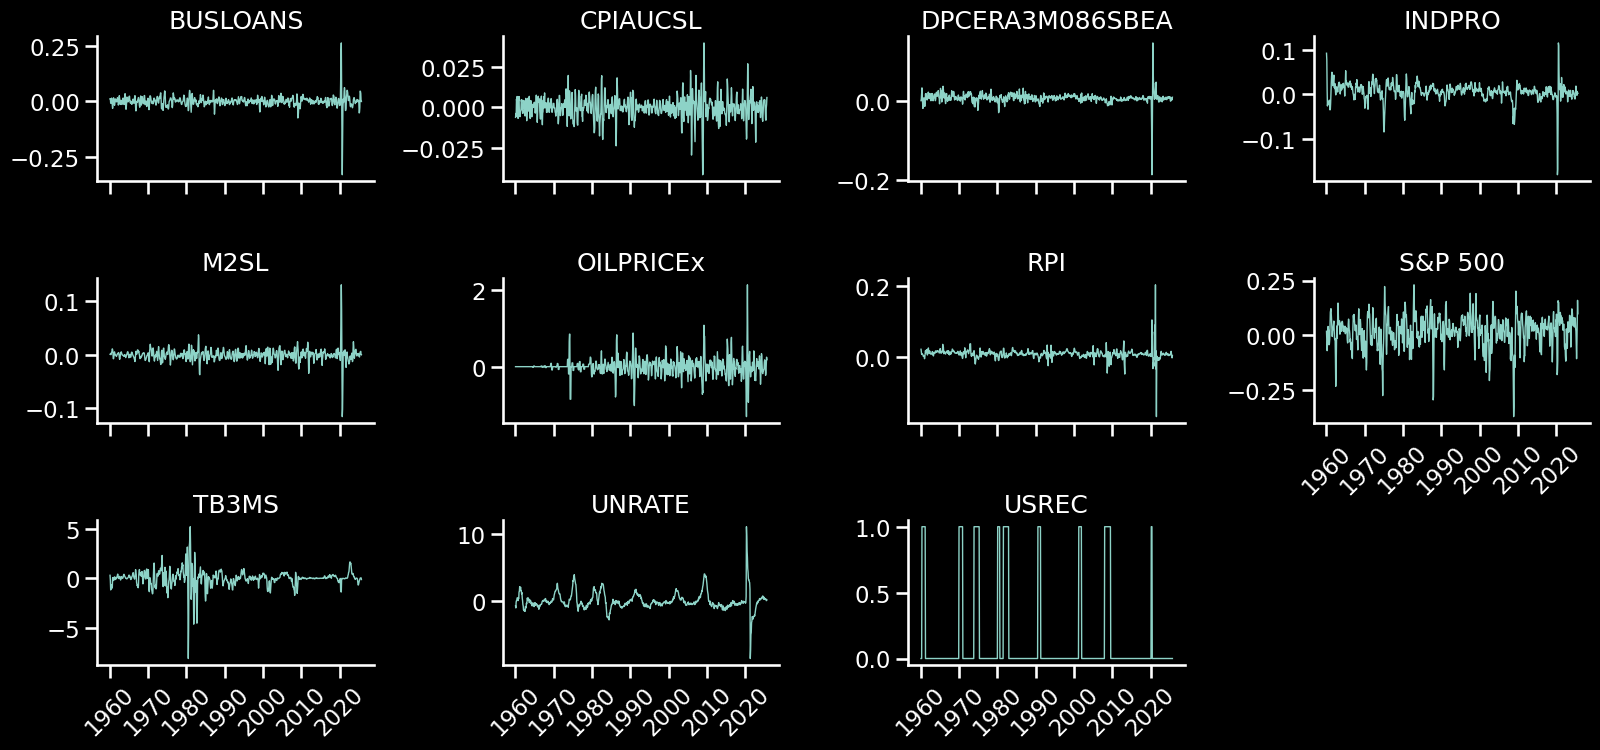

In [63]:
# s'assurer de l'ordre et du type de date
df_long = df_long.sort_values(["series", "date"]).copy()
df_long["date"] = pd.to_datetime(df_long["date"])

plt.style.use("dark_background")
sns.set_context("talk")

g = sns.relplot(
    data=df_long,
    x="date", y="value",
    col="series", col_wrap=4,
    kind="line", linewidth=1,
    facet_kws=dict(sharey=False),
    hue=None, legend=False,
    height=2.6, aspect=1.6
)

g.set_axis_labels("", "")
g.set_titles("{col_name}")

# Formatage des dates pour plus de lisibilité en fond sombre
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

for ax in g.axes.flat:
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(axis="x", labelrotation=45, colors="white")  # ⬅️ rotation à 45°
    ax.tick_params(axis="y", colors="white")
    ax.grid(False)

plt.show()

# Exporter la série stationnaire

In [64]:
df.to_csv("df.csv")
df_stationary.to_csv("df_stationary.csv")